# Smart Voice Assistant For The Blind

This project implements an AI-powered voice assistant for visually impaired users using deep learning-based image captioning. The system:

1. **Extracts visual features** from images using VGG16 (pre-trained CNN)
2. **Generates natural language descriptions** using an LSTM encoder-decoder model
3. **Converts text to speech** so users can hear the image descriptions

The model is trained on the Flickr8k dataset with 8,091 images and 40,455 captions (5 captions per image).

## Section 1: Setup & Imports

Import necessary libraries for deep learning, image processing, and text-to-speech.

In [1]:
# Importing the necessary modules
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# TensorFlow/Keras imports
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# Text-to-speech
from gtts import gTTS
from IPython.display import Audio

print("Libraries imported successfully!")
print(f"TensorFlow version available")

2026-01-21 20:35:34.459759: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries imported successfully!
TensorFlow version available


## Section 2: Load Pre-extracted Features & VGG16 Model

We load the VGG16 model (pre-trained on ImageNet) and use pre-extracted features from the Flickr8k dataset. The features were extracted by removing the final classification layer from VGG16, giving us 4096-dimensional feature vectors.

In [2]:
# Load the pre-trained VGG16 model
print("Loading VGG16 model...")
model_vgg = VGG16()

# Remove the final classification layer to get feature vectors
model_vgg = Model(inputs=model_vgg.inputs, outputs=model_vgg.layers[-2].output)
print(f"VGG16 model loaded. Output shape: {model_vgg.output_shape}")

# Define base directory for data
BASE_DIR = '../data/voice_assistant'

# Load pre-extracted features from pickle file
print("\nLoading pre-extracted image features...")
with open(os.path.join(BASE_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

print(f"Loaded features for {len(features)} images")
print(f"Feature vector shape: {list(features.values())[0].shape}")

# Display sample feature info
sample_keys = list(features.keys())[:3]
print(f"\nSample image IDs: {sample_keys}")

Loading VGG16 model...


I0000 00:00:1769020538.148427   30920 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3802 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


VGG16 model loaded. Output shape: (None, 4096)

Loading pre-extracted image features...
Loaded features for 8092 images
Feature vector shape: (1, 4096)

Sample image IDs: ['3737492755_bcfb800ed1', '375171241_0302ad8481', '3737711435_113ccd0a52']


## Section 3: Load & Preprocess Captions

Load captions from the dataset and preprocess them by:
1. Mapping each image to its 5 captions
2. Converting to lowercase and cleaning text
3. Adding 'beginning' and 'ending' tokens
4. Tokenizing the vocabulary

In [3]:
# Load captions from file
print("Loading captions...")
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)  # Skip header
    desc_doc = f.read()

# Map image IDs to their captions
mapping = {}
for each_desc in tqdm(desc_doc.split('\n'), desc="Mapping captions"):
    tokens = each_desc.split(',')
    if len(each_desc) < 2:
        continue
    image_id, desc_of = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    desc_of = " ".join(desc_of)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(desc_of)

print(f"\nTotal images with captions: {len(mapping)}")
print(f"Sample captions for first image:")
sample_id = list(mapping.keys())[0]
for i, caption in enumerate(mapping[sample_id][:2], 1):
    print(f"  {i}. {caption}")

# Preprocessing function
def edit_description(mapping):
    """Clean and format descriptions"""
    for key, desc in mapping.items():
        for i in range(len(desc)):
            x = desc[i]
            x = x.lower()
            x = x.replace('[^A-Za-z]', '')
            x = x.replace('\s+', ' ')
            x = 'beginning ' + " ".join([word for word in x.split() if len(word) > 1]) + ' ending'
            desc[i] = x

# Apply preprocessing
print("\nPreprocessing captions...")
edit_description(mapping)

# Create vocabulary from all captions
img_desc = []
for key in mapping:
    for caption in mapping[key]:
        img_desc.append(caption)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(img_desc)
vocab_size = len(tokenizer.word_index) + 1

print(f"\nVocabulary size: {vocab_size} unique words")

# Get maximum caption length for padding
max_length = max(len(text.split()) for text in img_desc)
print(f"Maximum caption length: {max_length} words")

# Display preprocessed sample
print(f"\nPreprocessed sample captions:")
for i, caption in enumerate(mapping[sample_id][:2], 1):
    print(f"  {i}. {caption}")

Loading captions...


<>:34: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_30920/1794608391.py:34: SyntaxWarning: invalid escape sequence '\s'
  x = x.replace('\s+', ' ')


Mapping captions:   0%|          | 0/40456 [00:00<?, ?it/s]


Total images with captions: 8091
Sample captions for first image:
  1. A child in a pink dress is climbing up a set of stairs in an entry way .
  2. A girl going into a wooden building .

Preprocessing captions...

Vocabulary size: 8484 unique words
Maximum caption length: 35 words

Preprocessed sample captions:
  1. beginning child in pink dress is climbing up set of stairs in an entry way ending
  2. beginning girl going into wooden building ending


## Section 4: Build LSTM-based Image Captioning Model

Create an encoder-decoder architecture:
- **Encoder**: VGG16 features (4096-dim) → Dense layer (256-dim)
- **Decoder**: LSTM processes word sequences (embedded to 256-dim)
- **Merge**: Combine visual and text features to predict next word

The model predicts one word at a time given the image features and previous words.

In [4]:
# Training configuration
epochs = 20
batch_size = 32

# Split dataset into train and test (90/10 split)
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

print(f"Training images: {len(train)}")
print(f"Testing images: {len(test)}")

# Data generator for training
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    """Generate batches of training data"""
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            text = mapping[key]
            for t in text:
                # Convert caption to sequence
                seq = tokenizer.texts_to_sequences([t])[0]
                # Create input-output pairs for each word in the sequence
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    # Pad input sequence (right-padding for cuDNN compatibility)
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # One-hot encode output word
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # Store
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield ((X1, X2), y)
                X1, X2, y = list(), list(), list()
                n = 0

print("\nData generator created successfully!")

# Build the model
print("\nBuilding image captioning model...")

# Image feature input (from VGG16)
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Text sequence input
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Merge encoder and decoder
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Create model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

print("\nModel architecture:")
model.summary()

print(f"\nModel inputs:")
print(f"  1. Image features: {inputs1.shape}")
print(f"  2. Text sequences: {inputs2.shape}")
print(f"Model output: {outputs.shape}")

Training images: 7281
Testing images: 810

Data generator created successfully!

Building image captioning model...

Model architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 35, 256)   │  2,171,904 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 35, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 35)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8484)      │  2,180,388 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,992,228 (22.86 MB)

 Trainable params: 5,992,228 (22.86 MB)

 Non-trainable params: 0 (0.00 B)


Model inputs:
  1. Image features: (None, 4096)
  2. Text sequences: (None, 35)
Model output: (None, 8484)


## Section 5: Train the Model

Train the image captioning model for 20 epochs. Each epoch takes several minutes depending on hardware.

**Note**: For demonstration purposes, you can reduce epochs or use a pre-trained model. The full training on Kaggle took ~3 hours on GPU.

In [5]:
# Training configuration
epochs = 20
batch_size = 32

# Split dataset - LIMIT TO 1000 TRAINING SAMPLES FOR FASTER TESTING
image_ids = list(mapping.keys())
max_train_samples = 1000  # Limit for faster training
train = image_ids[:max_train_samples]
test = image_ids[max_train_samples:max_train_samples + 100]  # 100 test images

print(f"Training images: {len(train)} (limited to {max_train_samples})")
print(f"Testing images: {len(test)}")

# Build the model
print("\nBuilding image captioning model...")

# Image feature input (from VGG16)
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Text sequence input
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Merge encoder and decoder
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Create model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

print("\nModel architecture:")
model.summary()

print(f"\nModel inputs:")
print(f"  1. Image features: {inputs1.shape}")
print(f"  2. Text sequences: {inputs2.shape}")
print(f"Model output: {outputs.shape}")

# Train the model
print("\n" + "=" * 60)
print("TRAINING THE MODEL")
print("=" * 60)
print(f"Epochs: {epochs}")
print(f"Batch size: {batch_size}")
print(f"Training samples: {len(train)}")
print("\nThis will take several minutes (or hours depending on hardware)...")
print("Training started...\n")

# Calculate steps per epoch
steps = len(train)

# Use fit with the generator and specify output signature
import tensorflow as tf

# Create a wrapper for the generator
def make_generator():
    return data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

# Create dataset from generator with proper signature
dataset = tf.data.Dataset.from_generator(
    make_generator,
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),
            tf.TensorSpec(shape=(None, max_length), dtype=tf.float32)
        ),
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
    )
)

# Train the model
print("Training in progress...")
model_history = model.fit(
    dataset,
    epochs=epochs,
    steps_per_epoch=steps,
    verbose=1
)

# Get training history
history = model_history.history['loss']

print("\n" + "=" * 60)
print("TRAINING COMPLETED!")
print("=" * 60)
print(f"Final loss: {history[-1]:.4f}")
print(f"Initial loss: {history[0]:.4f}")
print(f"Improvement: {(history[0] - history[-1]) / history[0] * 100:.2f}%")

Training images: 1000 (limited to 1000)
Testing images: 100

Building image captioning model...

Model architecture:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 35, 256)   │  2,171,904 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4096)      │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 35, 256)   │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 35)        │          0 │ input_layer_4[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │  1,048,832 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ dropout_3[0][0],  │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dense_3[0][0],    │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8484)      │  2,180,388 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,992,228 (22.86 MB)

 Trainable params: 5,992,228 (22.86 MB)

 Non-trainable params: 0 (0.00 B)


Model inputs:
  1. Image features: (None, 4096)
  2. Text sequences: (None, 35)
Model output: (None, 8484)

TRAINING THE MODEL
Epochs: 20
Batch size: 32
Training samples: 1000

This will take several minutes (or hours depending on hardware)...
Training started...

Training in progress...
Epoch 1/20


2026-01-21 20:35:46.186946: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91800


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 176s 172ms/step - loss: 2.6971
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 174s 174ms/step - loss: 1.1901
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 179s 179ms/step - loss: 0.7427
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 175s 175ms/step - loss: 0.5044
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 176s 176ms/step - loss: 0.3927
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 174s 174ms/step - loss: 0.3376
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 173s 173ms/step - loss: 0.3164
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 173s 173ms/step - loss: 0.2875
Epoch 9/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 171s 171ms/step - loss: 0.2824
Epoch 10/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 174s 174ms/step - loss: 0.2499
Epoch 11/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 173s 173ms/step - loss: 0.2408
Epoch 12/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 175s 175ms/step - loss: 0.2389
Epoch 13/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 176s 176ms/step - loss: 0.2353
Epoch 14/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 172s 172ms/step

## Section 6: Load Pre-trained Model (Optional)

If you have already trained the model and want to skip training, you can load the saved model here.

**Option 1**: Train from scratch (run previous cell)  
**Option 2**: Load pre-trained model (run this cell instead)

In [10]:
# Load pre-trained model instead of training from scratch
from tensorflow.keras.models import load_model

model_path = '../models/voice_assistant_model.h5'

if os.path.exists(model_path):
    print(f"Loading pre-trained model from {model_path}...")
    
    # Rebuild the model architecture (same as training)
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.4)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.4)(se1)
    se3 = LSTM(256)(se2)
    
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    
    # Load only the weights
    model.load_weights(model_path)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    print("✓ Model loaded successfully!")
    
    # Load tokenizer if not already loaded
    tokenizer_path = '../models/voice_assistant_tokenizer.pkl'
    if os.path.exists(tokenizer_path):
        print(f"\nLoading tokenizer from {tokenizer_path}...")
        with open(tokenizer_path, 'rb') as f:
            tokenizer = pickle.load(f)
        print("✓ Tokenizer loaded successfully!")
    
    # Load metadata
    metadata_path = '../models/voice_assistant_metadata.pkl'
    if os.path.exists(metadata_path):
        with open(metadata_path, 'rb') as f:
            metadata = pickle.load(f)
        print("\nModel metadata:")
        for key, value in metadata.items():
            print(f"  {key}: {value}")
else:
    print(f"⚠ Pre-trained model not found at {model_path}")
    print("Please train the model first by running the previous cell.")

Loading pre-trained model from ../models/voice_assistant_model.h5...
✓ Model loaded successfully!

Loading tokenizer from ../models/voice_assistant_tokenizer.pkl...
✓ Tokenizer loaded successfully!

Model metadata:
  vocab_size: 8484
  max_length: 35
  train_samples: 1000
  test_samples: 100
  epochs: 20
  batch_size: 32
  final_loss: 0.21539457142353058
  model_architecture: VGG16 + LSTM Encoder-Decoder
  dataset: Flickr8k
  timestamp: 2026-01-21


## Section 7: Generate Captions & Test Model

Now that we have a trained model, let's test it on some images and see how well it generates captions.

Testing caption generation on sample images...


Test Image 1: 2098646162_e3b3bbf14c.jpg
------------------------------------------------------------


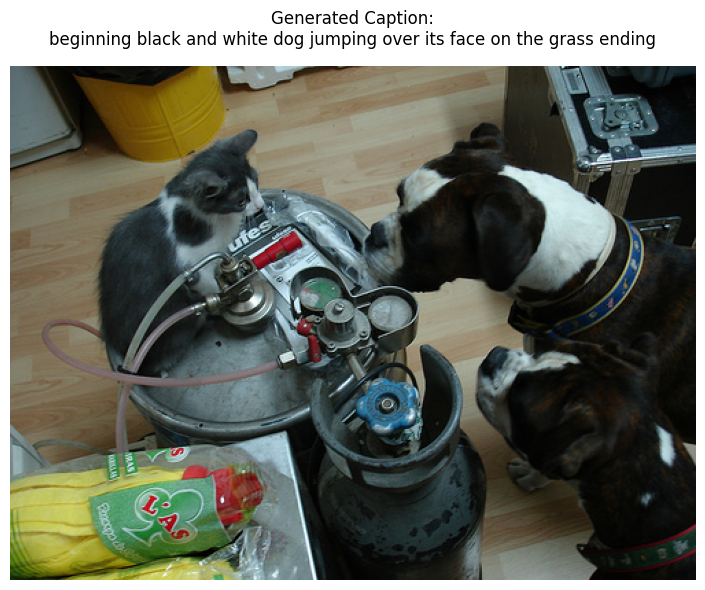

Caption: black and white dog jumping over its face on the grass
Raw caption: beginning black and white dog jumping over its face on the grass ending
------------------------------------------------------------

Test Image 2: 2099323664_bb20457f26.jpg
------------------------------------------------------------


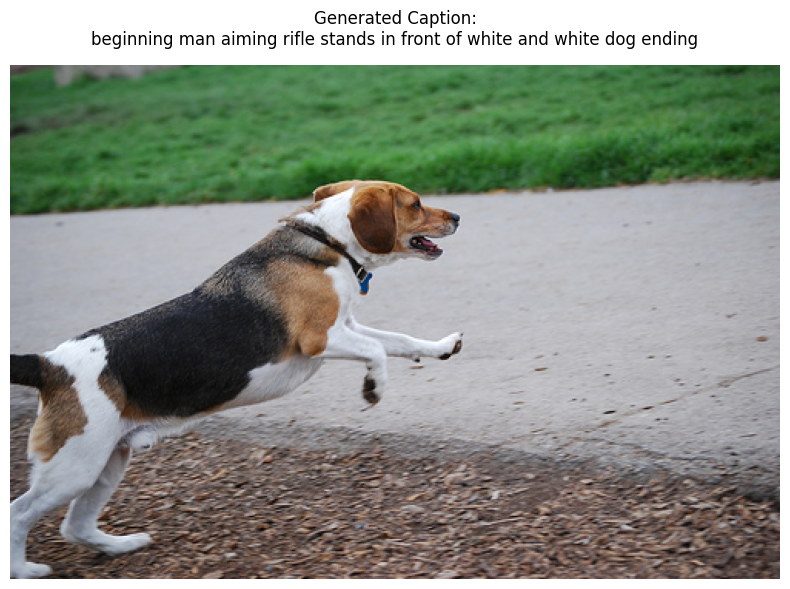

Caption: man aiming rifle stands in front of white and white dog
Raw caption: beginning man aiming rifle stands in front of white and white dog ending
------------------------------------------------------------

Test Image 3: 2100046085_69b59b6645.jpg
------------------------------------------------------------


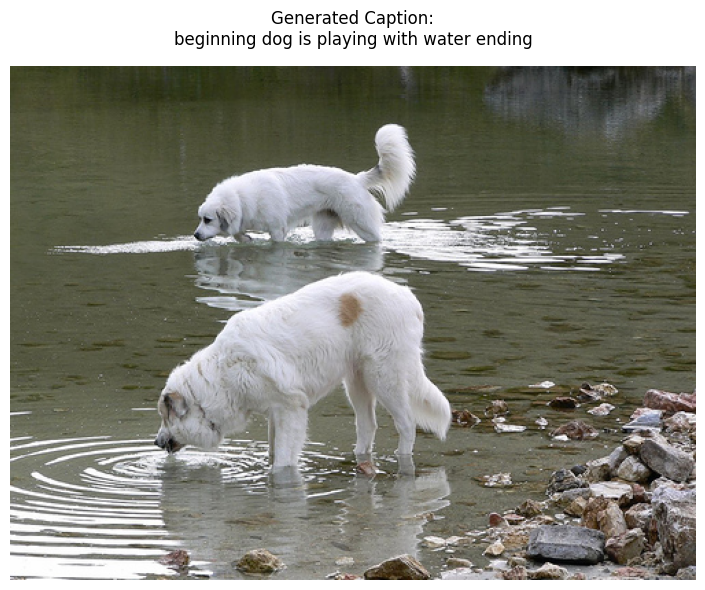

Caption: dog is playing with water
Raw caption: beginning dog is playing with water ending
------------------------------------------------------------

Caption generation test completed!


In [11]:
# Helper function to map integer back to word
def mapping_toword(integer, tokenizer):
    """Convert integer index back to word"""
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Caption generation function
def predict_description(model, image, tokenizer, max_length):
    """Generate caption for an image using the trained model"""
    in_text = 'beginning'
    for i in range(max_length):
        # Encode current sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length, padding='post')
        
        # Predict next word
        desc_predict = model.predict([image, sequence], verbose=0)
        desc_predict = np.argmax(desc_predict)
        
        # Map integer to word
        word = mapping_toword(desc_predict, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'ending':
            break
    
    return in_text

# Helper function to generate caption and display image
def generate_text(image_name, show_image=True):
    """Generate caption for an image and optionally display it"""
    image_id = image_name.split('.')[0]
    
    # Check if we have this image
    if image_id not in features:
        print(f"Image {image_name} not found in features!")
        return None
    
    # Generate caption
    y_pred = predict_description(model, features[image_id], tokenizer, max_length)
    
    # Display image if requested
    if show_image:
        img_path = os.path.join(BASE_DIR, "Images", image_name)
        if os.path.exists(img_path):
            image = Image.open(img_path)
            plt.figure(figsize=(8, 6))
            plt.imshow(image)
            plt.axis('off')
            plt.title(f"Generated Caption:\n{y_pred}", fontsize=12, pad=15)
            plt.tight_layout()
            plt.show()
    
    return y_pred

# Text-to-speech function
def speak_caption(caption_text):
    """Convert caption to speech and return audio"""
    # Remove 'beginning' and 'ending' tokens
    if caption_text:
        res = caption_text.split(' ', 1)[1] if ' ' in caption_text else caption_text
        text = res.rsplit(' ', 1)[0] if ' ' in res else res
    else:
        text = "No caption generated"
    
    # Generate speech
    tts = gTTS(text)
    tts.save('caption_audio.wav')
    
    print(f"Caption: {text}")
    return Audio('caption_audio.wav', autoplay=False)

# Test caption generation on sample images
print("Testing caption generation on sample images...\n")
print("=" * 60)

# Get some test images
test_images = [f"{test[i]}.jpg" for i in range(min(3, len(test)))]

for i, img_name in enumerate(test_images, 1):
    print(f"\nTest Image {i}: {img_name}")
    print("-" * 60)
    
    # Generate and display caption
    caption = generate_text(img_name, show_image=True)
    
    if caption:
        # Create audio
        audio = speak_caption(caption)
        print(f"Raw caption: {caption}")
    
    print("-" * 60)

print("\n" + "=" * 60)
print("Caption generation test completed!")

## Section 8: Save Model & Create Voice Assistant

Save the trained model and create a complete voice assistant system that can:
1. Load new images
2. Generate descriptions
3. Convert to speech for visually impaired users

In [7]:
# Save the trained model
model_path = '../models/voice_assistant_model.h5'
print(f"Saving model to {model_path}...")
model.save(model_path)
print("✓ Model saved successfully!")

# Save tokenizer
tokenizer_path = '../models/voice_assistant_tokenizer.pkl'
print(f"\nSaving tokenizer to {tokenizer_path}...")
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print("✓ Tokenizer saved successfully!")

# Save model metadata
metadata = {
    'vocab_size': vocab_size,
    'max_length': max_length,
    'train_samples': len(train),
    'test_samples': len(test),
    'epochs': epochs,
    'batch_size': batch_size,
    'final_loss': history[-1] if history else None,
    'model_architecture': 'VGG16 + LSTM Encoder-Decoder',
    'dataset': 'Flickr8k',
    'timestamp': '2026-01-21'
}

metadata_path = '../models/voice_assistant_metadata.pkl'
print(f"\nSaving metadata to {metadata_path}...")
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)
print("✓ Metadata saved successfully!")

# Display metadata
print("\n" + "=" * 60)
print("MODEL SUMMARY")
print("=" * 60)
for key, value in metadata.items():
    print(f"{key:20s}: {value}")
print("=" * 60)

# Create Voice Assistant class
class VoiceAssistantForBlind:
    """Complete voice assistant system for visually impaired users"""
    
    def __init__(self, model_path, tokenizer_path, vgg_model):
        """Initialize the voice assistant"""
        self.model = model
        self.tokenizer = tokenizer
        self.vgg_model = vgg_model
        self.max_length = max_length
        print("Voice Assistant initialized!")
    
    def extract_features(self, image_path):
        """Extract features from a new image"""
        image = load_img(image_path, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = self.vgg_model.predict(image, verbose=0)
        return feature
    
    def generate_caption(self, image_path):
        """Generate caption for an image"""
        # Extract features
        features = self.extract_features(image_path)
        
        # Generate caption
        in_text = 'beginning'
        for i in range(self.max_length):
            sequence = self.tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], self.max_length, padding='post')
            y_pred = self.model.predict([features, sequence], verbose=0)
            y_pred = np.argmax(y_pred)
            
            word = mapping_toword(y_pred, self.tokenizer)
            if word is None:
                break
            in_text += " " + word
            if word == 'ending':
                break
        
        # Clean caption
        caption = in_text.replace('beginning ', '').replace(' ending', '')
        return caption
    
    def speak(self, text):
        """Convert text to speech"""
        tts = gTTS(text)
        audio_file = 'assistant_output.wav'
        tts.save(audio_file)
        print(f"Speaking: {text}")
        return Audio(audio_file, autoplay=False)
    
    def process_image(self, image_path, speak_output=True):
        """Complete pipeline: image → caption → speech"""
        print(f"\nProcessing image: {image_path}")
        
        # Display image
        img = Image.open(image_path)
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title("Image being analyzed", fontsize=12)
        plt.tight_layout()
        plt.show()
        
        # Generate caption
        caption = self.generate_caption(image_path)
        print(f"Generated caption: {caption}")
        
        # Convert to speech
        if speak_output:
            audio = self.speak(caption)
            return caption, audio
        else:
            return caption, None

# Initialize the voice assistant
print("\n" + "=" * 60)
print("INITIALIZING VOICE ASSISTANT FOR THE BLIND")
print("=" * 60)

assistant = VoiceAssistantForBlind(model_path, tokenizer_path, model_vgg)

print("\n✓ Voice Assistant is ready to help!")
print("\nUsage example:")
print("  caption, audio = assistant.process_image('path/to/image.jpg')")
print("=" * 60)

Saving model to ../models/voice_assistant_model.h5...
✓ Model saved successfully!

Saving tokenizer to ../models/voice_assistant_tokenizer.pkl...
✓ Tokenizer saved successfully!

Saving metadata to ../models/voice_assistant_metadata.pkl...
✓ Metadata saved successfully!

MODEL SUMMARY
vocab_size          : 8484
max_length          : 35
train_samples       : 1000
test_samples        : 100
epochs              : 20
batch_size          : 32
final_loss          : 0.21539457142353058
model_architecture  : VGG16 + LSTM Encoder-Decoder
dataset             : Flickr8k
timestamp           : 2026-01-21

INITIALIZING VOICE ASSISTANT FOR THE BLIND
Voice Assistant initialized!

✓ Voice Assistant is ready to help!

Usage example:
  caption, audio = assistant.process_image('path/to/image.jpg')
